In [43]:
from torchvision.datasets import SVHN
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
import random

In [2]:
root_dir = '/home/tguenther/Data'
svhn = SVHN(root=root_dir, split='train', download=True, transform=transforms.ToTensor())

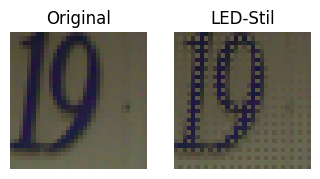

In [ ]:
def tensor_to_cv2_img(tensor):
    """
    Konvertiert einen PyTorch-Tensor (C, H, W) mit Werten [0,1]
    zu einem OpenCV-kompatiblen uint8-Bild (H, W, C).
    """
    array = tensor.numpy()
    array = array.transpose(1, 2, 0)  # C,H,W → H,W,C
    array = (array * 255).astype('uint8')
    return array

def get_background_color(image_array):
    small_image = cv2.resize(image_array, (32, 32), interpolation=cv2.INTER_AREA)
    pixels = small_image.reshape(-1, small_image.shape[-1])
    pixels_as_tuples = [tuple(pixel) for pixel in pixels]
    most_common_color = Counter(pixels_as_tuples).most_common(1)[0][0]
    return most_common_color

def apply_led_effect(
    img_rgb,
    dot_size=0,
    step=2,
    brightness_threshold=110,
    show_original_under_mask=True,
    invert=True
):
    """
    Simuliert LED-Ziffern durch Punktmatrix-Effekt.
    
    Parameter:
    - img_rgb: Eingabebild als RGB (uint8)
    - dot_size: Radius der Punkte
    - step: Gitterabstand
    - brightness_threshold: Schwelle für "LED an"
    - show_original_under_mask: Wenn True, wird Maske über Originalbild gelegt
    - invert: Invertiert den Bildhintergrund
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape

    background_color = tuple(int(i) for i in get_background_color(img_rgb))

    if invert:
        gray = 255 - gray

    # Basisbild für Darstellung
    if show_original_under_mask:
        base = img_rgb.copy()
    else:
        base = np.zeros((h, w, 3), dtype=np.uint8)

    # Punktmatrix erzeugen
    for y in range(0, h, step):
        for x in range(0, w, step):
            patch = gray[y:y+step, x:x+step]
            if patch.size == 0:
                continue
            brightness = patch.mean()
            if brightness > brightness_threshold:
                # cv2.circle(base, (x + step // 2, y + step // 2), dot_size, (255, 255, 255), -1)
                cv2.circle(base, (x + step // 2, y + step // 2), dot_size, background_color, -1)

    return base

# Bild laden (Tensor → RGB-Array)
img_tensor, label = svhn[1]
img_rgb = tensor_to_cv2_img(img_tensor)

led_img = apply_led_effect(
    img_rgb,
    dot_size=0,
    step=2,
    brightness_threshold=110,
    show_original_under_mask=True,
    invert=True
)

# Anzeige
plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
# plt.subplot(1, 3, 2); plt.imshow(led_img, cmap='gray', alpha=0.3); plt.title("LED-Raster"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(led_img); plt.title("LED-Stil"); plt.axis("off")
plt.show()

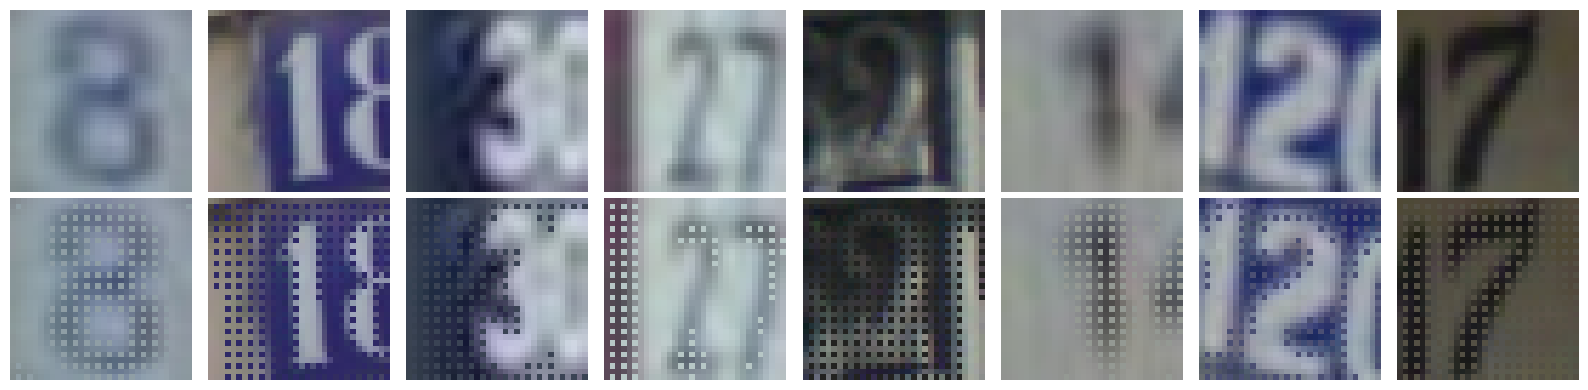

In [62]:
# Zufällige Auswahl von 8 Bildern
num_images = 8
random_indices = random.sample(range(len(svhn)), num_images)

# Initialisieren der 2x8-Plot-Matrix
fig, axes = plt.subplots(2, num_images, figsize=(16, 4))

# Anzeigen der zufällig ausgewählten Bilder
for i, idx in enumerate(random_indices):
    # Originalbild laden
    image, _ = svhn[idx]
    
    # Preprocessing: Beispielhafte Umwandlung zu Graustufen (ohne Größe zu ändern)
    preprocessed_image = transforms.functional.rgb_to_grayscale(image)

    # Bild vom Tensor zu einem Numpy-Array konvertieren
    original_image_np = image.permute(1, 2, 0).numpy()
    img_rgb = tensor_to_cv2_img(image)
    led_img = apply_led_effect(
    img_rgb,
    dot_size=0,
    step=2,
    brightness_threshold=110,
    show_original_under_mask=True,
    invert=True
)

    # Originalbild plotten
    axes[0, i].imshow(original_image_np)
    axes[0, i].axis('off')

    # Vorverarbeitetes Bild plotten
    axes[1, i].imshow(led_img, cmap='gray')
    axes[1, i].axis('off')

# Anpassen des Layouts
plt.tight_layout()
plt.show()